# Task 2: Regression 

**Student Name:** Jason Coleman

**Student ID:** 9539719

Open a new Jupyter notebook and name it etivity3_regression.ipynb. 

In this notebook, train three regression pipelines with **Random Forest**, **Linear Regression** and a **third regressor of your choice** as the final estimator, respectively, for *predicting the value of* `insurance_cost`.

## Requirements:

For each regressor, include data preparation and dimensionality reduction steps in the main pipeline.

* You can choose any regressor as the third one. Some options are SVR and MLPRegressor, but you are not limited to them.
* For the dimensionality reduction step use PCA, RFE and a third dimensionality reduction (incl. feature selection) technique in at least one pipeline.
* Use grid search for hyperparameter tuning and replicate the process in the example notebook Tutorial 3-2 - Regression and Dimensionality Reduction.ipynb to evaluate and compare the models you have trained and pick the best one.

Summarise your experience in a markdown cell (max 150 words in a markdown cell).

[Rubrik](https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=17939&rubricId=1755&originTool=quicklinks)

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler, QuantileTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn import svm
from sklearn.svm import SVR

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import SelectKBest, RFE
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedKFold

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns

# I use IPython to better format the outputs. You may need to install.
# %pip install ipython
from IPython.display import Markdown

In [2]:
import warnings 
from sklearn.exceptions import ConvergenceWarning
# I do the following knowingly as some 
# fits failed (and long warnings make 
# GitLab jupyter reviews painful).
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
df_metrics = pd.read_csv("./insurance.csv")
df_metrics.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

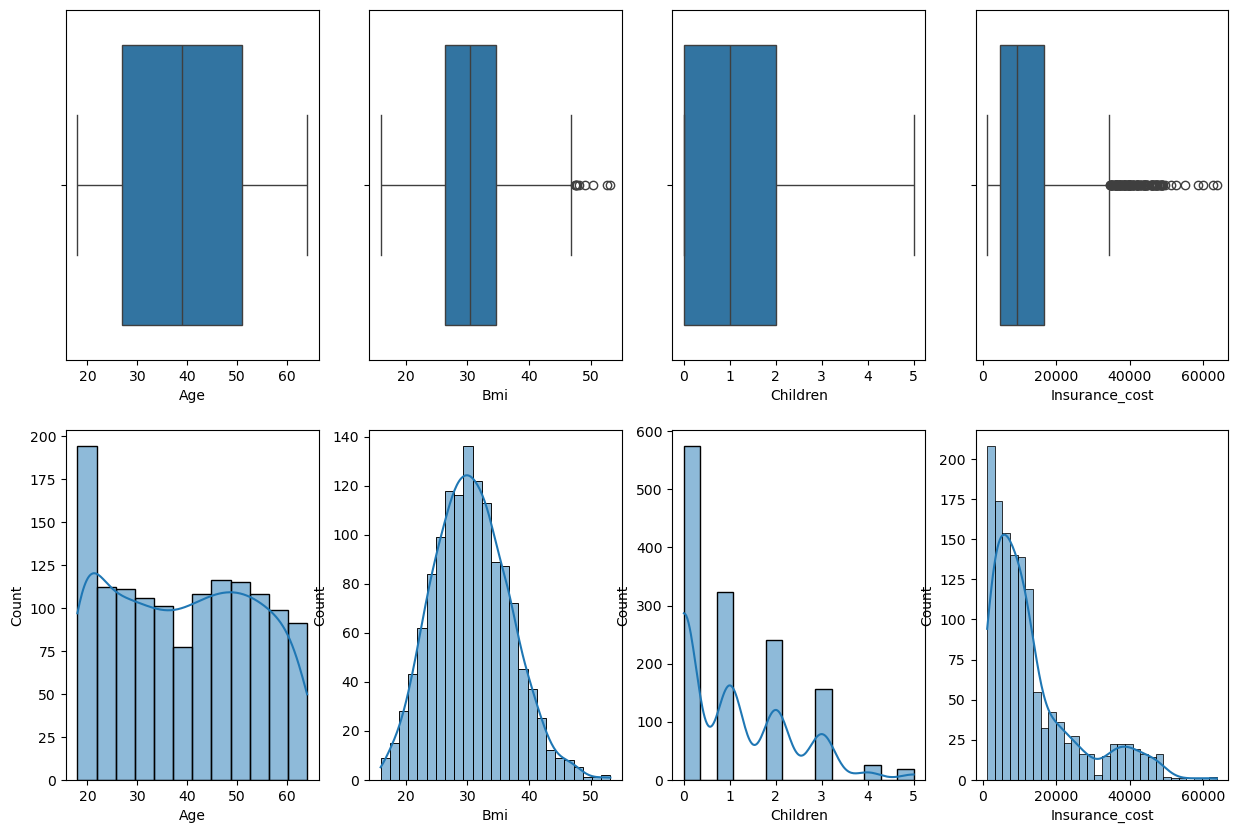

In [4]:
columns_to_plot = ['age', 'bmi', 'children', 'insurance_cost']

plt.figure(figsize=(15, 10))

for index, column in enumerate(columns_to_plot, start=1):
    plt.subplot(2, len(columns_to_plot), index)  # Create a subplot in the first row
    sns.boxplot(x=df_metrics[column])  # Create the boxplot for the column
    plt.xlabel(column.capitalize())  # Set the x-axis label with capitalized column name

for index, column in enumerate(columns_to_plot, start=1):
    plt.subplot(2, len(columns_to_plot), len(columns_to_plot) + index)  
    sns.histplot(df_metrics[column], kde=True) 
    plt.xlabel(column.capitalize())  

plt.show()

### Encoding Children
Does the number of children correlate with the cost of insurance?

In [5]:
# Calculate Pearson and Spearman correlations
pearson_corr = df_metrics['children'].corr(df_metrics['insurance_cost'], method='pearson')
spearman_corr = df_metrics['children'].corr(df_metrics['insurance_cost'], method='spearman') # better for discrete
print("Pearson Correlation Coefficient:", pearson_corr)
print("Spearman's Rank Correlation:", spearman_corr)

Pearson Correlation Coefficient: 0.06799822684790488
Spearman's Rank Correlation: 0.13333894319168216


Seems like very low correlation between the number of children and the cost of insurance. I may look into removing, or collapsing the children count into a Yes/No.

In [6]:
df_metrics.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

### Comments:

* `bmi` is almost gaussian (some outliers)
* `age` is almost uniform (some outliers in 0-20 age group)
* `insurance_cost` has a high, right skew (a lot of outliers). The maximum cost is far higher than the 3rd quartile. 
* `children` field has a high skew

#### Handling Outliers
Handling outliers has been bothering me for a while. This is partially because outliers can come in two main forms: **invalid** and **valid** [see 2. below]. The invalid data points are simply down to poor data entry or noise; that is, they are just wrong. Valid outliers are just values that are totally different to "the norm" (consider the CEO who is in a data set that has a salary field - their salary may be much higher than all other entries - it's not wrong, it's valid information). So, handling outliers means we need to understand the data and how it was collected.

# Create a target Variable for Regression

In [7]:
y = df_metrics['insurance_cost']
X = df_metrics.drop('insurance_cost', axis=1)

### Examine Outliers in Insurance Costs
I will use IQR as the data is skewed.

In [8]:
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = y[(y < lower_bound) | (y > upper_bound)]

print("IQR Lower Bound:", lower_bound)
print("IQR Upper Bound:", upper_bound)
print("Outliers:", outliers)

IQR Lower Bound: -13109.1508975
IQR Upper Bound: 34489.350562499996
Outliers: 9       36149.48350
33      34617.84065
38      36307.79830
40      38792.68560
82      34779.61500
           ...     
1300    47305.30500
1317    47291.05500
1319    47928.03000
1325    46889.26120
1336    49577.66240
Name: insurance_cost, Length: 139, dtype: float64


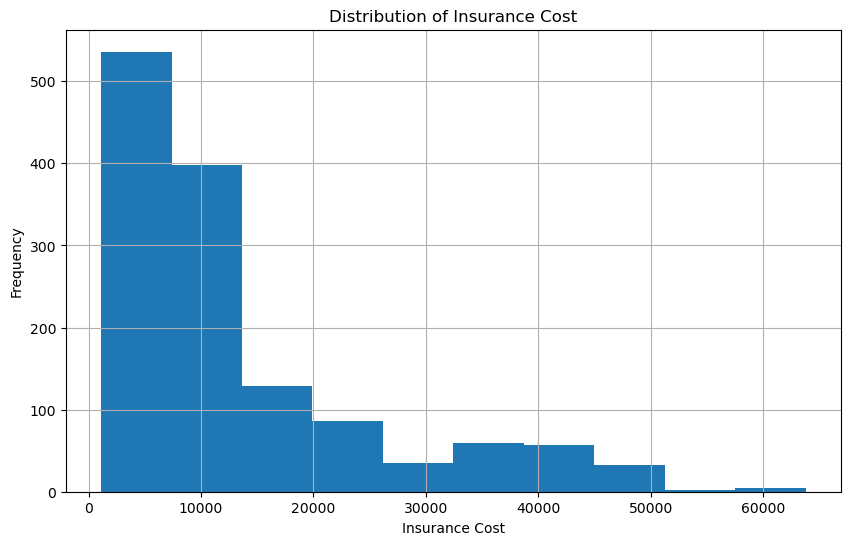

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df_metrics['insurance_cost'])
plt.title('Distribution of Insurance Cost')
plt.xlabel('Insurance Cost')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
# Calculate the third quartile (75th percentile) of insurance cost
third_quartile = df_metrics['insurance_cost'].quantile(0.75)

# Filter the DataFrame to select rows with insurance cost greater than the third quartile
filtered_df = df_metrics[df_metrics['insurance_cost'] > third_quartile]

filtered_df.describe()

age         bmi    children  insurance_cost
count  335.000000  335.000000  335.000000      335.000000
mean    40.188060   31.308582    1.179104    31108.444687
std     13.817583    5.843001    1.164924    10595.023690
min     18.000000   17.765000    0.000000    16657.717450
25%     28.000000   27.100000    0.000000    21302.112325
50%     42.000000   30.900000    1.000000    28923.136920
75%     52.000000   35.530000    2.000000    39726.566025
max     64.000000   52.580000    5.000000    63770.428010

I don't think we can just blindly remove these outliers. We should try to understand if they are erroneous or actually valid data in the context of the domain.

# Build Train/Test sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
X_train.head(5)

age  gender     bmi  children smoker     region
925   49  female  27.170         0     no  southeast
797   44  female  36.480         0     no  northeast
308   26  female  28.785         0     no  northeast
561   35    male  24.420         3    yes  southeast
542   34  female  23.560         0     no  northeast

In [12]:
y_train.head(5)

925     8601.32930
797    12797.20962
308     3385.39915
561    19361.99880
542     4992.37640
Name: insurance_cost, dtype: float64

Note: I will start by using the same data prep from the classification task but will use a more streamlined pipeline to make it easier to edit and review.

In [13]:
# Function to apply log transformation
def log_transform(x):
    return np.log(x + 1)

# Create a pipeline for skewed numerical features - likely children here - needs review
log_and_scale_pipeline = Pipeline([
    ('log_transformer', FunctionTransformer(log_transform, validate=False, feature_names_out='one-to-one')),
    ('scaler', MinMaxScaler())
])

In [14]:
def build_preprocessing_pipeline():
    """
        Feedback from Pierce Currid (https://learn.ul.ie/d2l/le/17939/discussions/threads/39807/View)
    """
    categorical_features = ['gender', 'smoker', 'region']

    return ColumnTransformer([
                ('cat', 
                    Pipeline([
                            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
                        ]), categorical_features),
                
                ('num', 
                    Pipeline([
                        ('quantile_transform', QuantileTransformer(n_quantiles=1000, output_distribution='uniform')),
                        ('scaler', MinMaxScaler())
                ]), ['bmi']),
                ('num_age', MinMaxScaler(), ['age']),
                #('num_children', MinMaxScaler(), ['children']), #Very little difference in outcomes, regardless of what I do with the Child field
                ('num_skewed', log_and_scale_pipeline, ['children']) 
            ], remainder='passthrough')

In [15]:


N_FEATURES_OPTIONS = [1, 2, 3, 4, 5, 6, 7, 8, 9]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8, 10, 20]

# Define the models associated pipelines and the param search spaces
# I do this to keep everything together - the pipeline is more data-driven this way.
models = {
    'random forest regressor': {
        'pipeline': Pipeline([
            ('preprocess', build_preprocessing_pipeline()),
            ('reduce_dim', 'passthrough'),
            ('ttr', TransformedTargetRegressor(
                regressor=RandomForestRegressor(n_estimators=50),
                func=log_transform, 
                inverse_func=np.expm1
                )
            )
        ]),
        'param_grid': [ 
            {
                # Use Recursive Feature Elimination with an SVR estimator
                'reduce_dim': [RFE(SVR(kernel='rbf', C=0.1, gamma='auto'))],
                'reduce_dim__n_features_to_select':N_FEATURES_OPTIONS,
                'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
                'ttr__regressor__min_samples_split': [2, 5, 10]
            },
            {
                # Use Recursive Feature Elimination with a Linear Regression estimator
                'reduce_dim': [RFE(LinearRegression())],
                'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
                'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
                'ttr__regressor__min_samples_split': [2, 5, 10]
            },
            {
                # Use KernelPCA
                'reduce_dim': [KernelPCA()],
                'reduce_dim__kernel': ['linear', 'poly', 'rbf'], 
                'reduce_dim__n_components': N_FEATURES_OPTIONS,  # Assuming PCA uses same options
                'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
                'ttr__regressor__min_samples_split': [2, 5, 10]
            },
            {
                'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS,
                'ttr__regressor__min_samples_split': [2, 5, 10]           
            }
        ]
    },
    'linear regressor': {
            'pipeline': Pipeline([
                ('preprocess', build_preprocessing_pipeline()),
                ('reduce_dim', 'passthrough'),
                ('ttr', TransformedTargetRegressor(
                    regressor=LinearRegression(),
                    func=log_transform,
                    inverse_func=np.expm1
                    )
                )
            ]), # try Recursive feature elimination with cross-validation with Linear Regression (does this improve things)
            'param_grid': [
                {
                    'reduce_dim': [RFECV(SVR(kernel='rbf', C=100), step=1, cv = StratifiedKFold(5), scoring="accuracy")],
                    'reduce_dim__min_features_to_select': N_FEATURES_OPTIONS,
                    'ttr__regressor__fit_intercept': [True, False]
                },
                {
                    'reduce_dim': [RFECV(LinearRegression(), step=1, cv = StratifiedKFold(5), scoring="accuracy")],
                    'reduce_dim__min_features_to_select': N_FEATURES_OPTIONS,
                    'ttr__regressor__fit_intercept': [True, False]
                },
                {
                    'reduce_dim': [KernelPCA()],
                    'reduce_dim__kernel': ['linear', 'poly', 'rbf'], 
                    'reduce_dim__n_components': N_FEATURES_OPTIONS,
                    'ttr__regressor__fit_intercept': [True, False]                    
                },
                {
                    'ttr__regressor__fit_intercept': [True, False]                    
                }
            ]
        },
    'MLP regressor': {
        'pipeline': Pipeline([
            ('preprocess', build_preprocessing_pipeline()),
            ('reduce_dim', 'passthrough'),
            ('ttr', TransformedTargetRegressor(
                regressor=MLPRegressor(max_iter=100000),
                func=log_transform,
                inverse_func=np.expm1
                )
            )
        ]),
        'param_grid': [
                {
                    'reduce_dim': [KernelPCA()],
                    'reduce_dim__kernel': ['linear', 'poly', 'rbf'], 
                    'reduce_dim__n_components': N_FEATURES_OPTIONS,
                    'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)],
                    'ttr__regressor__activation': ['relu', 'tanh', 'logistic'],
                    'ttr__regressor__solver': ['adam', 'sgd']
                },
                {
                    'reduce_dim': [RFE(LinearRegression())],
                    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
                    'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)],
                    'ttr__regressor__activation': ['relu', 'tanh', 'logistic'],
                    'ttr__regressor__solver': ['adam', 'sgd']
                },            
                {
                    'reduce_dim': [RFE(SVR(kernel='linear'))],
                    'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
                    'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)],
                    'ttr__regressor__activation': ['relu', 'tanh', 'logistic'],
                    'ttr__regressor__solver': ['adam', 'sgd']
                },            
                {
                    'ttr__regressor__hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)],
                    'ttr__regressor__activation': ['relu', 'tanh', 'logistic'],
                    'ttr__regressor__solver': ['adam', 'sgd']
                }
            ]
    }
}

# Fit Models

## Utility Functions

In [16]:
def evaluate_model(X_test, y_test, model):
    
    _predicted_values = model.predict(X_test)
        
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

def format_best_params(best_params):
    params_list = [f"{key}={value}" for key, value in best_params.items()]
    return ', '.join(params_list)

def grid_search_to_markdown(grid_search_details):
    header = "| Model | Best CV Score | Best Parameters |"
    separator = "|---|---|---|"
    rows = [header, separator]
    
    for model, details in grid_search_details.items():
        best_params = format_best_params(details['Best Parameters'])
        row = f"| {model} | {details['Best CV Score']:.3f} | {best_params} |"
        rows.append(row)
    
    return "\n".join(rows)

def metrics_to_markdown(metrics):

    # Start with the header row
    header = "| Model | " + " | ".join(list(metrics[next(iter(metrics))].keys())) + " |"
    separator = "|---" * (len(metrics[next(iter(metrics))]) + 1) + "|"
    
    # Generate the rows for each model
    rows = []
    for model, stats in metrics.items():
        row = f"| {model} | " + " | ".join(f"{value:.4f}" if isinstance(value, float) else str(value) for value in stats.values()) + " |"
        rows.append(row)
    
    # Combine all parts and return the full table
    markdown_table = header + "\n" + separator + "\n" + "\n".join(rows)
    return markdown_table

Fit models and evaluate

In [17]:
results = {}
data = {'Model':[], 'MSE': [], 'MAE': [], 'R2': [], 'Model': []}
grid_search_details = {}

for name, model in models.items():
    
    search = GridSearchCV(model['pipeline'], model['param_grid'], cv=5, n_jobs=-1, refit=True)

    search.fit(X_train, y_train)

    grid_search_details[name] = {
        'Best CV Score': search.best_score_,
        'Best Parameters': search.best_params_
    }    
    
    mse, mae, r2 = evaluate_model(X_test, y_test, search.best_estimator_)

    # Collecting data for plotting
    data['Model'].append(name)
    data['MSE'].append(mse)
    data['MAE'].append(mae)
    data['R2'].append(r2)

    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2} 

/Users/jasoncoleman/anaconda3/envs/keras-tensorflow/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (749). n_quantiles is set to n_samples.
  warnings.warn(
/Users/jasoncoleman/anaconda3/envs/keras-tensorflow/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (749). n_quantiles is set to n_samples.
  warnings.warn(
/Users/jasoncoleman/anaconda3/envs/keras-tensorflow/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (749). n_quantiles is set to n_samples.
  warnings.warn(
/Users/jasoncoleman/anaconda3/envs/keras-tensorflow/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (748). n_quantiles is set to n_samples.
  warnings.wa

# Results
First some definitions. 

- **Mean Squared Error (MSE):** Measures the average squared difference between predicted and actual values. Lower values, closer to zero, are better. The ceiling depends on the sample set but can be compared relatively to the MSE of other regressors.

$$
\text{MSE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n - 1} (y_i - \hat{y}_i)^2.
$$

- **Mean Absolute Error (MAE):** Captures the average magnitude of the errors between predicted and actual values. Lower values, closer to zero, are better.  

$$
\text{MAE}(y, \hat{y}) = \frac{1}{n} \sum_{i=0}^{n-1} \left| y_i - \hat{y}_i \right|.
$$

- **R-squared ($R^2$):** *Represents the proportion of variance in the dependent variable (target) that can be explained by the independent variables* (features)[[see link]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html). This score gives some insight into how well the model will handle new, unseen data. Its value can be negative but the maximum is 1. A value of 1 is the best possible score.

In [18]:
markdown_table = metrics_to_markdown(results)
display(Markdown(markdown_table))

markdown_table = grid_search_to_markdown(grid_search_details)
display(Markdown(markdown_table))

| Model | MSE | MAE | R2 |
|---|---|---|---|
| random forest regressor | 19572064.1269 | 2062.2061 | 0.8683 |
| linear regressor | 57395683.4704 | 4298.2944 | 0.6139 |
| MLP regressor | 26105447.7866 | 2730.5543 | 0.8244 |

| Model | Best CV Score | Best Parameters |
|---|---|---|
| random forest regressor | 0.850 | ttr__regressor__max_depth=6, ttr__regressor__min_samples_split=2 |
| linear regressor | 0.617 | reduce_dim=KernelPCA(), reduce_dim__kernel=rbf, reduce_dim__n_components=7, ttr__regressor__fit_intercept=True |
| MLP regressor | 0.826 | reduce_dim=RFE(estimator=SVR(kernel='linear')), reduce_dim__n_features_to_select=5, ttr__regressor__activation=relu, ttr__regressor__hidden_layer_sizes=(50, 50), ttr__regressor__solver=adam |

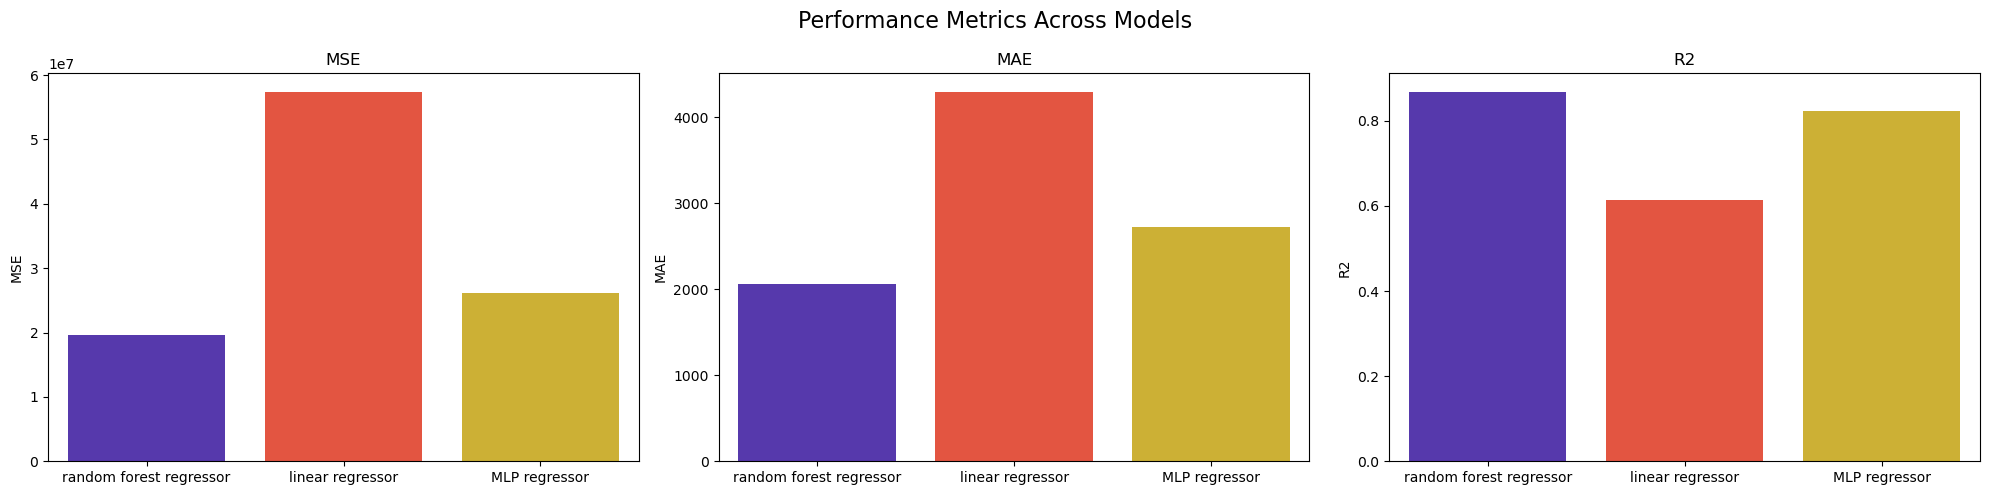

In [19]:
df_metrics = pd.DataFrame(data)

palette = sns.color_palette("CMRmap", len(df_metrics['Model'].unique()))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('Performance Metrics Across Models', fontsize=16)

for i, metric in enumerate(['MSE', 'MAE', 'R2']):
    sns.barplot(x='Model', y=metric, data=df_metrics, ax=axes[i], palette=palette)
    axes[i].set_title(metric)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

# Conclusions

Random Forest has the best MSE, MAE and $R^2$ values, followed closely by the MLP Regressor. Linear Regression is our worst performing regressor (still better than 50/50), for this setup. 

Notes: 

- Using a robustscaler on the input data reduced the best CV scores (especially for LinearRegression)
- Using KernalPCA with Linear Regression causes a small improvement in R2, MSE and MAE.
- Outlier processing had little impact on the final result.

## Rubrik Checklist

- Created preprocessing pipeline - investigated outliers and focused on scaling
- All models trained with pipelines (including dimension reduction techniques - each gridsearch included a no-dim reduction option to determine if dimensiotn reduction actually caused an issue)
- Pipelines are the source of all processing, dim reduction and classification - no extraneous steps other than the initial addition of the new column for the target variable
- Experimented with alternative ways to structure code to aid reading and minmise mistakes (id likely have more utility modules and test code in real situations)
- Added PCA (with the kernel trick), RFE and RFECV dimension reduction techniques
- Grid search used a range of hyperparameter option (BayesSearch would be an avenue to investigate - given the training and eval times)
- Use 3 regressors: MLP regressor, Random Forest regressor and linear regressor
- Model evaluation - MSE, MAE, $R^2$. 

# References

1. [Isolation Forests](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest)
2. [Fundamentals of Machine Learning for Predictive Data Analytics Algorithms, Worked Examples, and Case Studie, page 66](https://mitpress.mit.edu/9780262029445/fundamentals-of-machine-learning-for-predictive-data-analytics/)